### Initialization cells 

In [1]:
import tigre

In [2]:
%pylab nbagg

from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


### Initialization of Variables

In [3]:
proj = np.load('projections.npy')

energies = []
fluence = []

with open('/home/xcite/xpecgen/xpecgen/data/MV_spectra/Al_spectrum_6.txt') as f:
    for line in f:
        energies.append(float(line.split()[0]))
        fluence.append(float(line.split()[1]))
        
original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
fluence_small = np.interp(original_energies_keV[1:],np.array(energies), fluence)

### Normalizing the analytical to the MC

In [4]:
primary = np.load('./primary_kernel_int_larger.npy')
original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

primary_512 = (primary[:,::2,:,:] + primary[:,1::2,:,:])/2
primary_512_64 = np.tile(primary_512,[1,1,2,1])
primary_512_64_15 = primary_512_64[1:]
fluence_small = np.interp(original_energies_keV[1:],np.array(energies), fluence)
primary_summed = primary_512_64_15.T @ (fluence_small)/np.sum(fluence_small)
primary_projections = np.sum(primary_summed,0)

### Now run the code

In [5]:
noise = np.load('/home/xcite/xpecgen/tests/noise_projections.npy')

### Now lets subtract the analytical to get the noise

In [6]:
proj_water = np.load('projections_water.npy')

fluence_small = np.interp(original_energies_keV,np.array(energies), fluence)

noise_summed = noise.T @ (fluence_small)/np.sum(fluence_small)

noise_projections = np.sum(noise_summed,0)

analytical_summed = np.array(proj).T @ weights_small
mean_analytical = np.mean(analytical_summed[:,:,0],1)

mean_proj = np.mean(proj_water[0].T,0)
raw_noise = np.sum(noise_summed,0)
raw_noise = np.mean(raw_noise,0)
raw_prime = np.mean(primary_projections,0)

def get_rmse(x):

    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_prime))

scale = minimize(get_rmse,[10,32])

def get_rmse_noise(x):

    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_noise))

scale = minimize(get_rmse,[10,32])
scale_noise = minimize(get_rmse_noise,[10,32])

raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
# raw_proj_noise = raw_proj + 

NameError: name 'mean_analytical' is not defined

### Actual working code! 

<IPython.core.display.Javascript object>


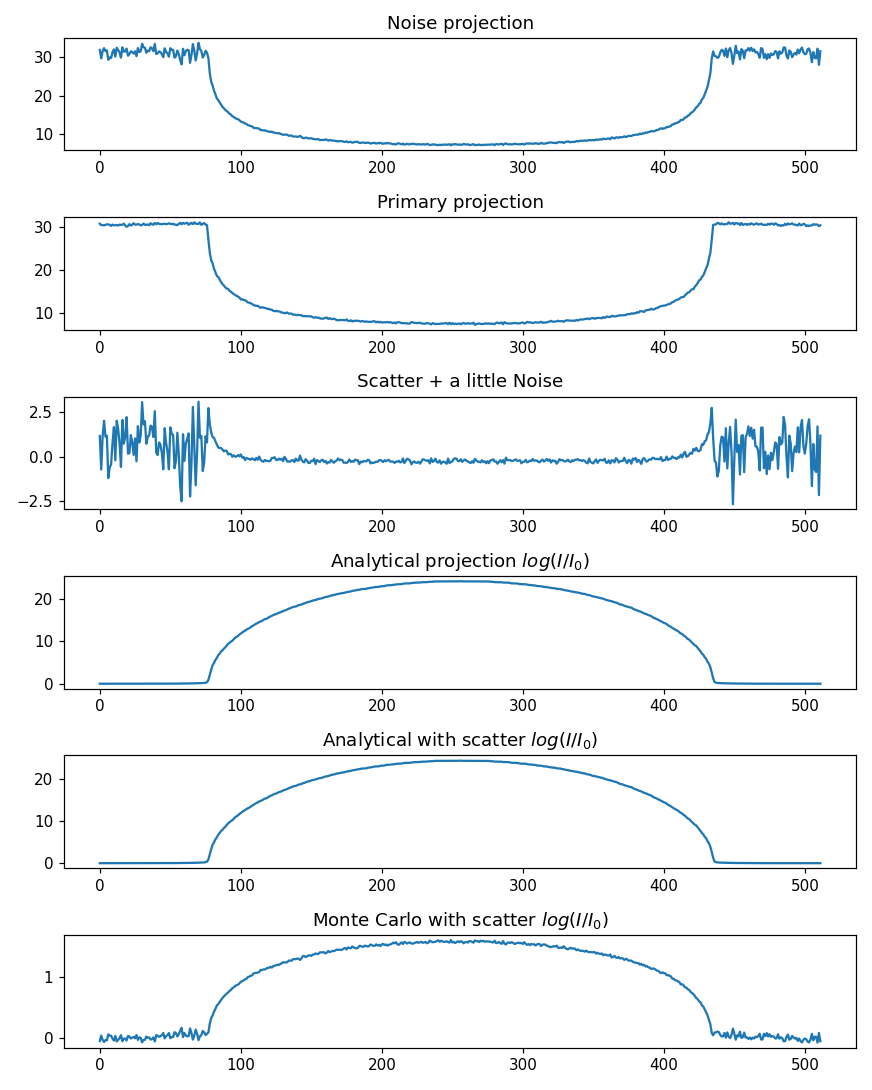

<IPython.core.display.Javascript object>


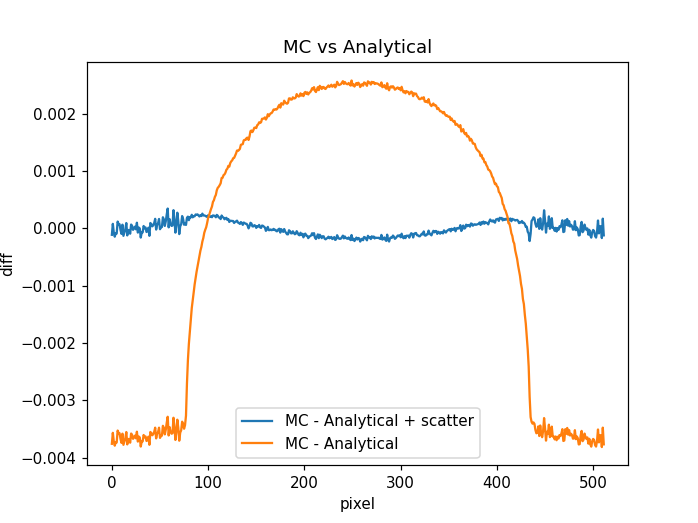

Text(0, 0.5, 'diff')

In [42]:
noise = raw_noise - raw_prime

raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
raw_proj_noise = np.exp(-mean_analytical/scale_noise.x[0])*scale_noise.x[1]

proj_w_scatter = -np.log(raw_proj_noise/scale_noise.x[1])*scale_noise.x[0]

plt.subplot(614)
plt.plot(mean_analytical)
plt.title('Analytical projection $log(I/I_0)$')
plt.subplot(615)
plt.plot(proj_w_scatter)
plt.title('Analytical with scatter $log(I/I_0)$')


noise_projections = np.sum(noise_summed,0)

fit = [-8.63229252e-05,  4.31027881e-02,  2.97682238e+01]

noise_proj = np.mean(-np.log(noise_projections/np.tile(np.polyval(fit,np.arange(0,512)),[64,1])),0)

plt.subplot(616)
plt.plot(noise_proj)
plt.title('Monte Carlo with scatter $log(I/I_0)$')

plt.tight_layout()

plt.figure()
plt.plot((noise_proj/np.sum(noise_proj) - proj_w_scatter/np.sum(proj_w_scatter)),label='MC - Analytical + scatter')
plt.plot((noise_proj/np.sum(noise_proj) - raw_proj/np.sum(raw_proj)),label='MC - Analytical')
plt.legend()
plt.title('MC vs Analytical')
plt.xlabel('pixel')
plt.ylabel('diff')


### Now lets apply it to the whole thing

#### Get the primary

In [76]:
primary_large = np.load('./primary_kernel_int_larger.npy')

primary_512 = (primary_large[:,::2,:,:] + primary_large[:,1::2,:,:])/2

primary_512_64 = np.tile(primary_512,[1,1,2,1])

primary = primary_512_64[1:]

#### get the noise (easy)

In [77]:
noise = np.load('noise_projections.npy')

# noise = noise - primary

# raw_proj = np.exp(-analytical/scale.x[0])*scale.x[1]

# raw_proj += noise

# proj_w_scatter = -np.log(raw_proj/scale.x[1])*scale.x[0]

#### get the analytical (hard)

In [15]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

angles = np.linspace(0,2*np.pi,90)

In [16]:
phantom = np.load('../xpecgen/data/phantoms/catphan_low_contrast_256.npy')
# phantom_mapping = ['air','water','bone','brain','bone']
phantom_mapping = ['air','water','water','water','water','water','water','water','water']

# Don't want to look for zeros
useful_phantom = phantom != 0

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

deposition_summed = np.array([    0.        ,  2395.25927928,  3434.7986552 ,  4416.62822646,
    5373.00952021,  6067.40938147,  6955.18365258,  7901.50699458,
    8860.76810654, 20457.403665  , 22916.6726841 , 26069.46417263,
   29726.25290966, 31589.13314065, 49335.93687135])

masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
mapping_functions = []

# Get the mapping functions for the different tissues
for ii in range(1,len(phantom_mapping)):

    mapping_functions.append(xg.get_mu(phantom_mapping[ii])) # density of water
    masks[ii-1] = phantom == ii

geo = tigre.geometry_default(high_quality=False,nVoxel=phantom.shape)
geo.DSD = 1500
geo.nDetector = np.array([64,512])
geo.dDetector = np.array([0.672, 0.672])
geo.sDetector = geo.dDetector * geo.nDetector

geo.accuracy = 0.1
geo.sVoxel = np.array((160, 160, 160)) 
geo.dVoxel = geo.sVoxel/geo.nVoxel 
# angles = np.linspace(0, 0, 1, dtype=np.float32)

energy = 100

phantom2 = phantom.copy().astype(np.float32)

proj = []

for energy in original_energies_keV[1:]:
    for ii in range(0,len(phantom_mapping)-1):

        phantom2[masks[ii].astype(bool)] = mapping_functions[ii](energy)*.997

    proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))

In [18]:
analytical = np.array(proj)

In [19]:
# Turns out noise does

noise_small = np.sum(noise,3)
primary_small = np.sum(primary,3)

noise_only = noise_small - primary_small

ValueError: operands could not be broadcast together with shapes (16,512,64) (15,512,64) 

In [20]:
noise_only_small = np.mean(noise_only,2)

NameError: name 'noise_only' is not defined

### Now we have to collapse the noise with the spectrum

In [21]:
out = []

det = 'CWO'

s = xg.Spectrum()

energies = []
fluence = []

spectrum_file = 'Al_spectrum_6'

with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
    for line in f:
        energies.append(float(line.split()[0]))
        fluence.append(float(line.split()[1]))

# Check if MV

fluence_small = np.interp(original_energies_keV[1:],np.array(energies), fluence)

weights_small = fluence_small*deposition_summed

weights_small /= np.sum(weights_small)

noise_weighted = noise_small.transpose([2,1,0]) @ weights_small

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 16)

In [22]:
s.x = np.array(energies)*1000  # to keV
s.y = np.array(fluence)

dump_files = os.path.join(
    xg.data_path, "Detectors", det, '*phsp.npy')
energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

kernel, kernels = xg.get_kernel(
                        s, dump_files, energy_deposition_file)

(17,) (17,)


In [23]:
kernels.shape

(17, 50, 50)

In [24]:
# np.save('weights_small',weights_small)
np.save('kernels',kernels)

In [87]:
proj_filt = proj.copy()
proj_new = proj.copy()

for kk in range(len(angles)):
    for ii in range(len(original_energies_keV)-1):
        
        # check if it is zero
        sum_kern = np.sum(kernels[ii+1])
        
#         # open er up and add the noise
#         proj_new[ii][kk] = -np.log((np.exp(-proj[ii][kk]/scale.x[0])*scale.x[1] 
#                                     + np.tile(noise_only_small[ii,:],[64,1]))/scale.x[1])*scale.x[0]
        
        if sum_kern > 0:

            proj_filt[ii] = fftconvolve(proj[ii][kk],kernels[ii+1]/sum_kern, mode = 'same')
            
        else:
            
            proj_filt[ii] = np.zeros(proj_filt[ii].shape)
                                    
    out.append(np.array(proj_filt).T@weights_small)

In [88]:
proj_2 = np.array(proj).transpose([3,2,1,0])@weights_small

im_1 = fftconvolve(proj_2[:,:,0],kernel.kernel/np.sum(kernel.kernel), mode = 'same')

In [89]:
proj_2 = np.array(proj).transpose([3,2,1,0])@weights_small

im_2 = fftconvolve(proj_2,np.tile(kernel.kernel/np.sum(kernel.kernel),[len(angles),1,1]), mode = 'same')

In [90]:
 np.array(proj).shape

(15, 90, 64, 512)

In [91]:
from scipy.optimize import minimize

In [28]:
# load the arrays
primary_large = np.load('./primary_kernel_int_larger.npy')
noise = np.load('noise_projections.npy')
proj_water = np.load('projections_water.npy')
# Resize the primary monte carlo
primary_512 = (primary_large[:,::2,:,:] + primary_large[:,1::2,:,:])/2
primary_512_64 = np.tile(primary_512,[1,1,2,1])
primary = primary_512_64[1:]

np.append(weights_small,0).shape

(16,)

In [31]:
# sum the noise kernel with the weights
# noise_summed = noise.T @ weights_small
# weight the primary
primary_summed = primary.T @ weights_small
# analytical
analytical_summed = np.array(proj).T @ weights_small

# Get a 2d sum
primary_projections = np.sum(primary_summed,0)
# raw_noise = np.sum(noise_summed,0)
# analytical_summed = np.mean(analytical_summed,0) # ??

# Average the primary in 1d
raw_prime = np.mean(primary_projections,0)
# analytical_summed = np.array(proj).T @ weights_small
# # mean_analytical = np.mean(analytical_summed[:,:,0],1)
# raw_noise = np.mean(raw_noise,0)

In [32]:
raw_prime.shape

(512,)

<IPython.core.display.Javascript object>


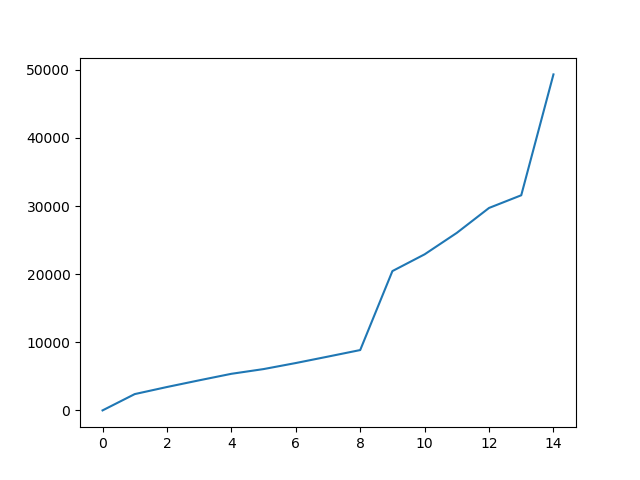

In [97]:
plt.figure()
plt.plot(deposition_summed)

In [93]:
plt.figure()
plt.plot(raw_prime)
plt.plot(mean_analytical)
plt.plot(raw_noise)

<IPython.core.display.Javascript object>

In [94]:
def get_rmse(x):
    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_prime))

def get_rmse_noise(x):
    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_noise))

scale = minimize(get_rmse,[10,32])
scale_noise = minimize(get_rmse_noise,[10,32])

raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
# get the noise
raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
raw_proj_noise = np.exp(-mean_analytical/scale_noise.x[0])*scale_noise.x[1]
scatter = raw_proj_noise - raw_proj

# proj_w_scatter = -np.log(raw_proj/scale_noise.x[1])*scale.x[0]

# Reshape the projections
weighted_projs = np.array(proj).transpose([3,2,1,0])
# Downsize the kernel
small_kernel = (kernel.kernel[::2,::2] 
                 + kernel.kernel[1::2,::2] 
                 + kernel.kernel[::2,1::2] 
                 + kernel.kernel[1::2,1::2])/4
# Normalize the kernel
kernel_norm = small_kernel/np.sum(small_kernel)
# log(i/i_0) to get back to intensity
raw = np.exp(-weighted_projs/scale.x[0])*scale.x[1]
# Weight the intensity by fluence
raw_weighted = raw@weights_small
# Add the already weighted noise
raw_weighted += np.tile(noise,[len(angles),raw_weighted.shape[1],1]).T
# add the poisson noise
noise_level = 1
raw_weighted = numpy.random.poisson(lam=raw_weighted/noise_level)*noise_level
# empty array to write the convolution to
filtered = raw_weighted.copy()

for ii in range(len(angles)):

    filtered[:,:,ii] = fftconvolve(raw_weighted[:,:,ii],kernel_norm, mode = 'same')

# resize with the extra intensity from the noise
proj_w_scatter = -np.log(filtered/scale_noise.x[1])*scale_noise.x[0]

MemoryError: Unable to allocate 17.5 GiB for an array with shape (1350, 1736704) and data type float64

In [ ]:
fig, ax = plt.subplots(1, 1)

X = proj_w_scatter

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [ ]:
proj_w_scatter.transpose([2,0,1]).shape

In [ ]:
kernel.kernel = (kernel.kernel[::2,::2] + kernel.kernel[1::2,::2] + kernel.kernel[::2,1::2] + kernel.kernel[1::2,1::2])/4

In [ ]:
plt.figure()
plt.imshow(kernel.kernel)

In [ ]:
kernel.kernel.shape

In [ ]:
plt.figure()
plt.imshow((im_1.T - out[0].T)/(out[0].T + 1))

In [ ]:
plt.figure()
plt.imshow(proj_2[:,:,0])

In [ ]:
fig, ax = plt.subplots(1, 1)

X = np.array(proj_filt).T

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [ ]:
proj_new

### Junk

In [ ]:
# noise_projections = np.sum(noise_summed,0)

fit = [-8.63229252e-05,  4.31027881e-02,  2.97682238e+01]

noise_proj = np.mean(-np.log(noise_projections/np.tile(np.polyval(fit,np.arange(0,512)),[64,1])),0)

In [ ]:
noise = raw_noise - raw_prime

raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]

raw_proj += noise

proj_w_noise = -np.log(raw_proj/scale.x[1])*scale.x[0]

In [ ]:
inds = [ii < 70 or ii > 440 for ii in range(primary_projections.shape[1])]

edges = np.mean(primary_projections,0)[inds]

fit = np.polyfit([i for i, x in enumerate(inds) if x],edges,6)

symmetric_fit = np.concatenate((np.polyval(fit,np.arange(0,256)),np.polyval(fit,np.arange(0,256))[-1::-1]))

# log_primary_projections = -np.log(primary_projections/np.tile(np.polyval(fit,np.arange(0,512)),[64,1]))
log_primary_projections = -np.log(primary_projections/np.tile(symmetric_fit,[64,1]))

In [ ]:
from numpy import genfromtxt

In [ ]:
xy = genfromtxt("/home/xcite/xpecgen/xpecgen/data/fluence2dose/f2d.csv",delimiter =',')

In [ ]:
%pylab

In [ ]:
plt.figure()
plt.loglog(xy[0],xy[1])

In [ ]:
xy.T[1]

In [ ]:
from scipy.io import loadmat

In [ ]:
dat = loadmat('/home/xcite/Downloads/Spektr3.0/SPEKTR3.0/Spektr Code/spektrFluencePerExposure.mat')

In [ ]:
dat['fluence_per_exposure']

In [ ]:
plt.figure()
plt.plot(dat['fluence_per_exposure'][:,0])

In [134]:
x = np.load('/home/xcite/xpecgen/xpecgen/data/Detectors/CuGOS/EnergyDeposition.npy',allow_pickle=True)

In [137]:
1000000/2.8

357142.85714285716

<IPython.core.display.Javascript object>


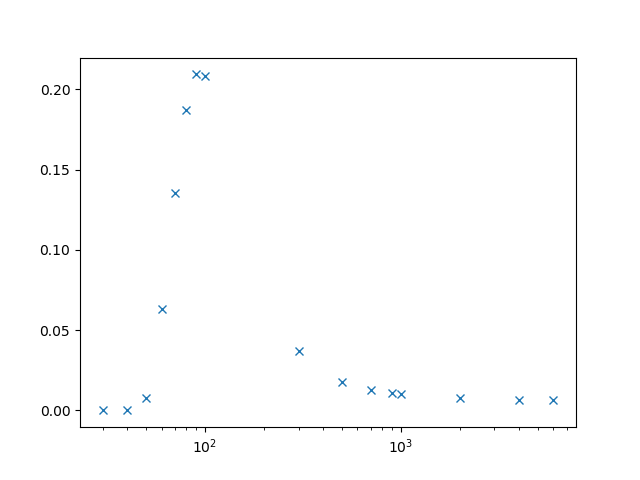

In [136]:
plt.figure()
plt.semilogx(x[1],(x[0]/(x[1]/1000))/(1000000/2.8),'x')

<IPython.core.display.Javascript object>


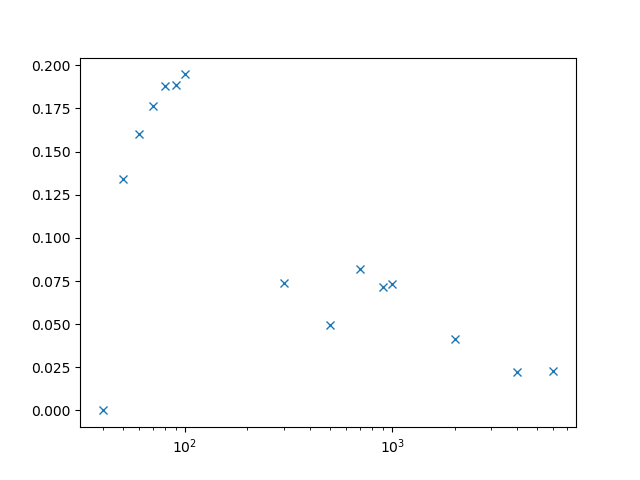

In [138]:
x = np.load('/home/xcite/xpecgen/xpecgen/data/Detectors/CWO/EnergyDeposition.npy',allow_pickle=True)

plt.figure()
plt.semilogx(x[1][1:],(x[0]/(x[1][1:]/1000))/(1000000/2.8),'x')

In [102]:
x[0]

array([2.20104113e-01, 2.77125657e-01, 0.00000000e+00, 1.96995959e+03,
       2.60260474e+03, 2.91568921e+03, 3.12820386e+03, 3.25876440e+03,
       3.43013672e+03, 3.50743604e+03, 3.58047900e+03, 3.65675513e+03,
       3.69098853e+03, 4.10769482e+03, 4.29139893e+03, 4.42303125e+03,
       4.47239453e+03, 4.52930664e+03, 4.53944336e+03, 4.62595654e+03,
       4.63272021e+03, 4.66860840e+03, 4.83433740e+03, 4.90872363e+03,
       4.95604443e+03, 4.98702051e+03, 4.95212891e+03])